In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score
pd.set_option('display.float_format', lambda x: '%.10f' % x)
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
subway_data ='NewYork_Taxi.csv'
events_data ='NewYorkEvents.csv'
city = 'NewYork'

## 1.1: Import Transportation Data

In [3]:
# import data
df_main = pd.read_csv(subway_data)

# change to datetime format
df_main['Date'] = pd.to_datetime(df_main['Date'])

# Aggregate on date
df_main = pd.DataFrame(df_main.groupby(['Date'])['amount'].sum())

# sort by index
df_main = df_main.sort_index()

# print details
print(df_main.info())
df_main.head()

KeyboardInterrupt: 

## 1.2: Import Events Data

In [30]:
# import events data
df_events = pd.read_csv(events_data, encoding = "ISO-8859-1", parse_dates=['Date'], infer_datetime_format=True)

# dataframe for events
df_finalEvents =  df_events[['Date', 'Type']]

# list events
lis_event = df_finalEvents['Type'].unique()
lis_event = list(lis_event)

## 1.3: Visualize Time Series with Events

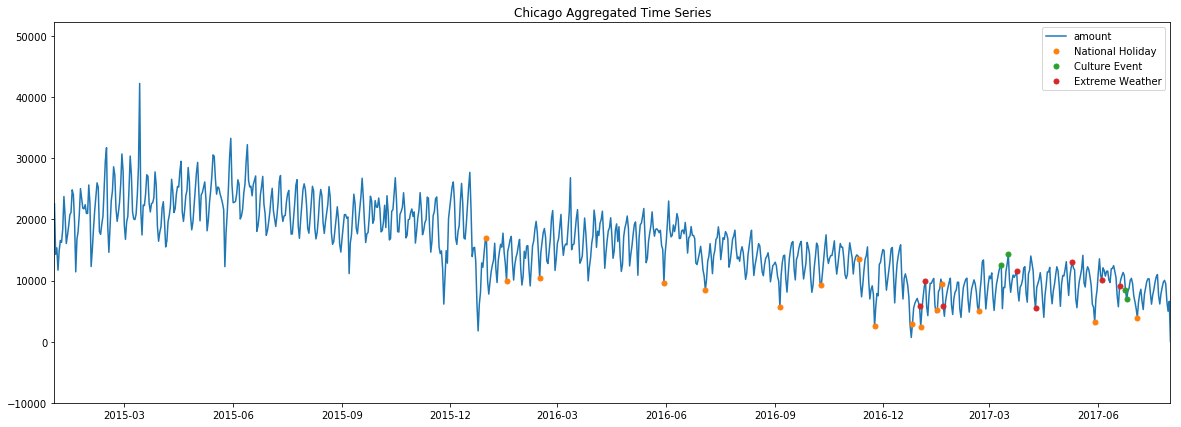

In [77]:
# Plot ridership
plt.figure(figsize=(20, 7))
plt.plot(df_main.index, df_main['amount'])

for event in lis_event:
    plt.plot(df_main[df_main.index.isin(df_finalEvents.loc[df_finalEvents['Type'] == event, 'Date'])].index,\
             df_main[df_main.index.isin(df_finalEvents.loc[df_finalEvents['Type'] == event, 'Date'])].amount,\
             '.', label = event, markersize = 10)

plt.ylim(df_main['amount'].min()-10000,df_main['amount'].max()+10000)
plt.xlim(min(df_main.index),max(df_main.index))
plt.title(city+" Aggregated Time Series")
plt.legend()
plt.savefig('/projects/cusp19_anomaly_detect/shared/Plots/'+city+"AggregatedTimeSeries.png")

## 1.4: Visualize Autocorrelation in Data

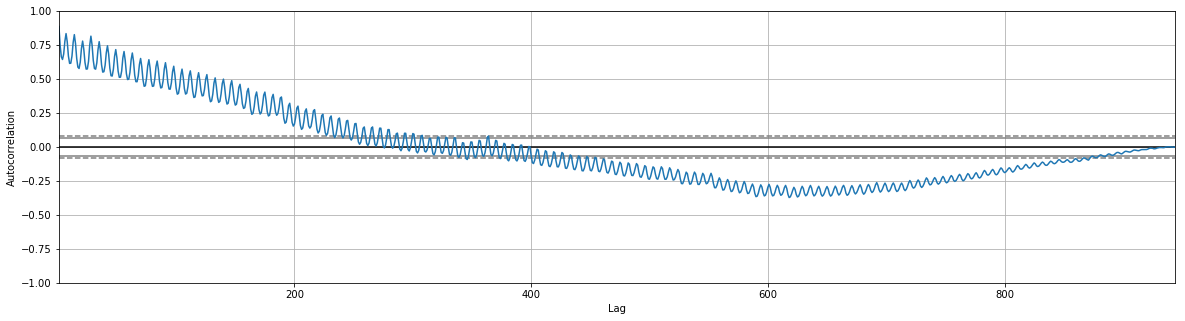

In [78]:
# plot autocorrelation in the data
plt.figure(figsize=(20, 5))
ax = autocorrelation_plot(df_main['amount'])
pd.DataFrame(data= {'Lag': np.linspace(1,14, num=14) , 'AutoCorr': ax.lines[5].get_data()[1][0:14]})
plt.title(city+" Aggregated Autocorrelation")
plt.savefig('/projects/cusp19_anomaly_detect/shared/Plots/'+city+"AggregatedAutocorrelation.png")

## 2.1: ARIMA Model

In [62]:
# fit model
model = ARIMA(df_main['amount'], order=(7,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.amount   No. Observations:                  943
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -8587.318
Method:                       css-mle   S.D. of innovations           2178.091
Date:                Fri, 12 Apr 2019   AIC                          17192.635
Time:                        18:44:57   BIC                          17236.277
Sample:                    01-02-2015   HQIC                         17209.269
                         - 08-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -14.6545     32.019     -0.458      0.647     -77.410      48.101
ar.L1.D.amount    -0.1175      0.032     -3.662      0.000      -0.180      -0.055
ar.L2.D.amount    -0.3534      0.032

In [63]:
# create residuals and predictions
df_residuals = pd.DataFrame(model_fit.resid, columns=['residuals'])

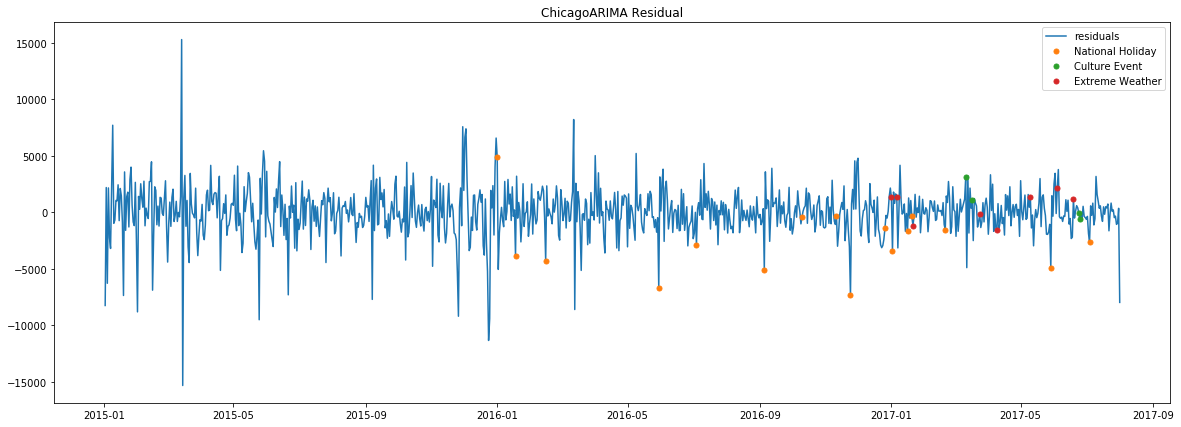

In [79]:
# Visualize events on residuals
plt.figure(figsize=(20, 7))
plt.plot(df_residuals.index, df_residuals.residuals)
for event in lis_event:
    plt.plot(df_residuals[df_residuals.index.isin(df_finalEvents.loc[df_finalEvents['Type'] == event, 'Date'])].index,\
             df_residuals[df_residuals.index.isin(df_finalEvents.loc[df_finalEvents['Type'] == event, 'Date'])].residuals,\
             '.', label = event, markersize = 10)
plt.legend()
plt.title(city+"ARIMA Residual")
plt.savefig('/projects/cusp19_anomaly_detect/shared/Plots/'+city+"ArimaResidual.png")

## 3.1: Detect Outlier

In [67]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [80]:
df_confMat = pd.DataFrame()
for thres in range(0, 36, 1):
    th = thres/10
    arr_outliers = is_outlier(df_residuals['residuals'], thresh = th)
    df_residuals['Outliers'] = arr_outliers
    for event in lis_event:
        df_temp = pd.DataFrame(columns=['Cat', 'Thres','TPR', 'FPR'])
        df_temp.loc[0,'Cat'] = event
        df_temp.loc[0,'Thres'] = th
        df_temp.loc[0, 'TPR'] = len(df_residuals[df_residuals.index.isin(df_finalEvents.loc[df_finalEvents['Type'] == event,'Date']) & df_residuals['Outliers'] == True])\
                                /len(df_residuals[df_residuals.index.isin(df_finalEvents.loc[df_finalEvents['Type'] == event, 'Date'])])
        df_temp.loc[0, 'FPR'] = len(df_residuals[(~df_residuals.index.isin(df_finalEvents['Date'])) & df_residuals['Outliers'] == True])\
                                /len(df_residuals[~df_residuals.index.isin(df_finalEvents['Date'])])
        df_confMat = df_confMat.append(df_temp)

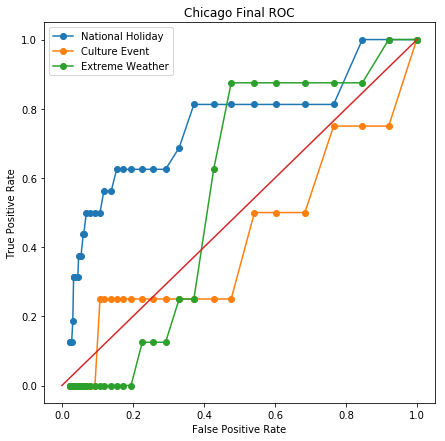

In [82]:
plt.figure(figsize=(7, 7))

for i in lis_event:
    df_temp = df_confMat[df_confMat['Cat'] == i]
    plt.plot(df_temp['FPR'],df_temp['TPR'], '-' ,marker = 'o' ,label = i)
    
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10), '-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(city+" Final ROC")
plt.savefig('/projects/cusp19_anomaly_detect/shared/Plots/'+city+"FinalROC.png")